In [84]:
import numpy as np
import matplotlib.pyplot as plt

from SEdist import SE_distribution
from kNN_CDFs import CDFkNN

import scipy.stats as stats
from scipy.interpolate import interp1d

plt.rc("text", usetex=True)
plt.rcParams["font.size"] = 32
plt.rcParams["figure.figsize"] = [16.34, 13]

In [85]:
boxsize = 250
NPois = 100000
seed = 42

np.random.seed(seed)

X = np.random.uniform(0, boxsize, NPois)
Y = np.random.uniform(0, boxsize, NPois)
Z = np.random.uniform(0, boxsize, NPois)

x_Poisson = np.vstack((X,Y,Z)).T.reshape(NPois, 3)

Nplg = int(NPois ** 0.3334) # make a lattice with approximately the same number as the input data
xpoi = boxsize * (np.arange(0, Nplg) + 0.5) / Nplg
xoutg = np.array(np.meshgrid(xpoi, xpoi, xpoi, indexing="xy"))
xoutg = xoutg.T.reshape(Nplg ** 3, 3)

Vbar = boxsize**3/NPois

In [86]:
kneighbors = np.arange(250)+1 # get first __ nearest neighbors (starts at k=1)
CDFs  = CDFkNN(x_Poisson, xoutg, kneighbors=kneighbors, periodic=boxsize,compress="log",Ninterpolants=500)

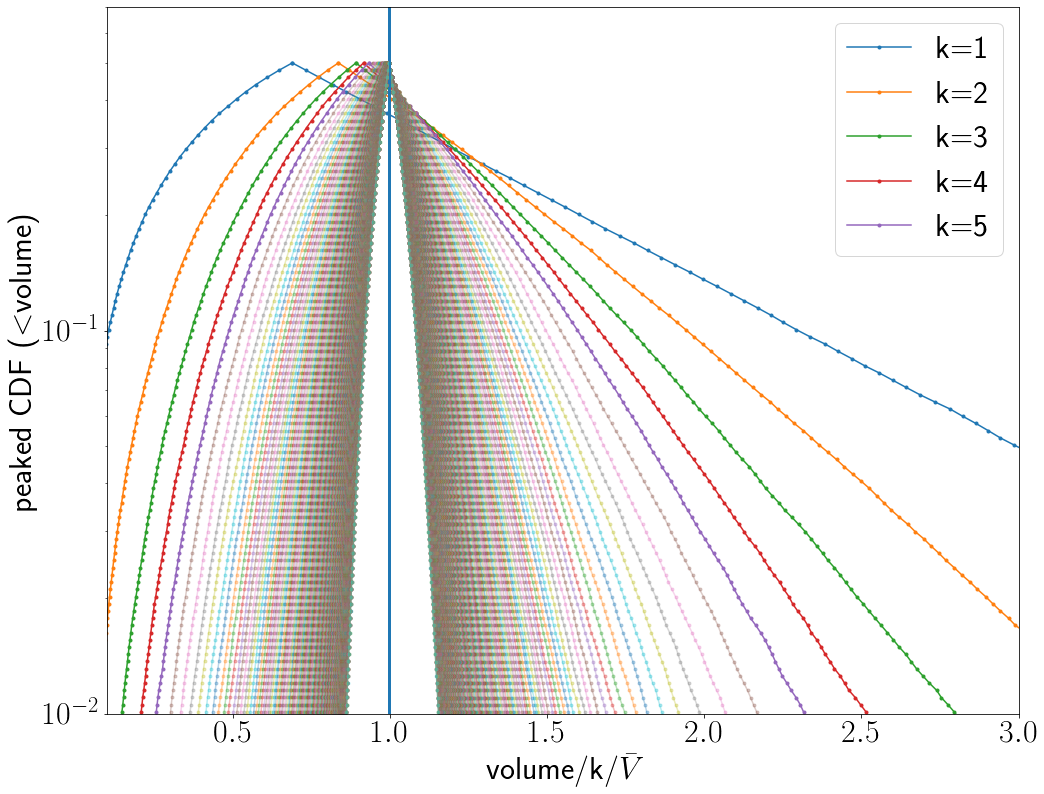

In [87]:
for k in kneighbors:
    vol = CDFs[k].f.x
    lab = ""
    af = 0.3
    if (k < 6) :
        lab = "k="+str(k)
        af = 1

    plt.semilogy(vol/k/Vbar, CDFs[k].pcdf(vol),'.-',alpha=af, label=lab)
    plt.axvline(CDFs[k].mean()/k/Vbar)
    
plt.axvline(Vbar)
plt.xlim([1e-1,3])
plt.ylim([1e-2,.7])
plt.ylabel("peaked CDF ($<$volume)")
plt.xlabel(r"volume/k/$\bar{V}$")
plt.legend();

In [88]:
Pks = { k-1: interp1d(CDFs[k].f.x,CDFs[k-1].cdf(CDFs[k].f.x)-CDFs[k].cdf(CDFs[k].f.x), bounds_error=False,fill_value=(0,0))  for k in kneighbors[1:]}
Pks.update({ 0: interp1d(CDFs[1].f.x,1-CDFs[1].cdf(CDFs[1].f.x), bounds_error=False,fill_value=(0,0)) })

from scipy.special import gamma, gammaln
def Erlang(k, lam, x):
    if k == 0:
        klamx = lam * x
        gammak = 1
    else:
        klamx = k * lam * x
        gammak = gamma(k)
#    return (klamx) ** k / gammak * np.exp(-klamx)
    return np.exp(k*np.log(klamx) -klamx -gammaln(k))

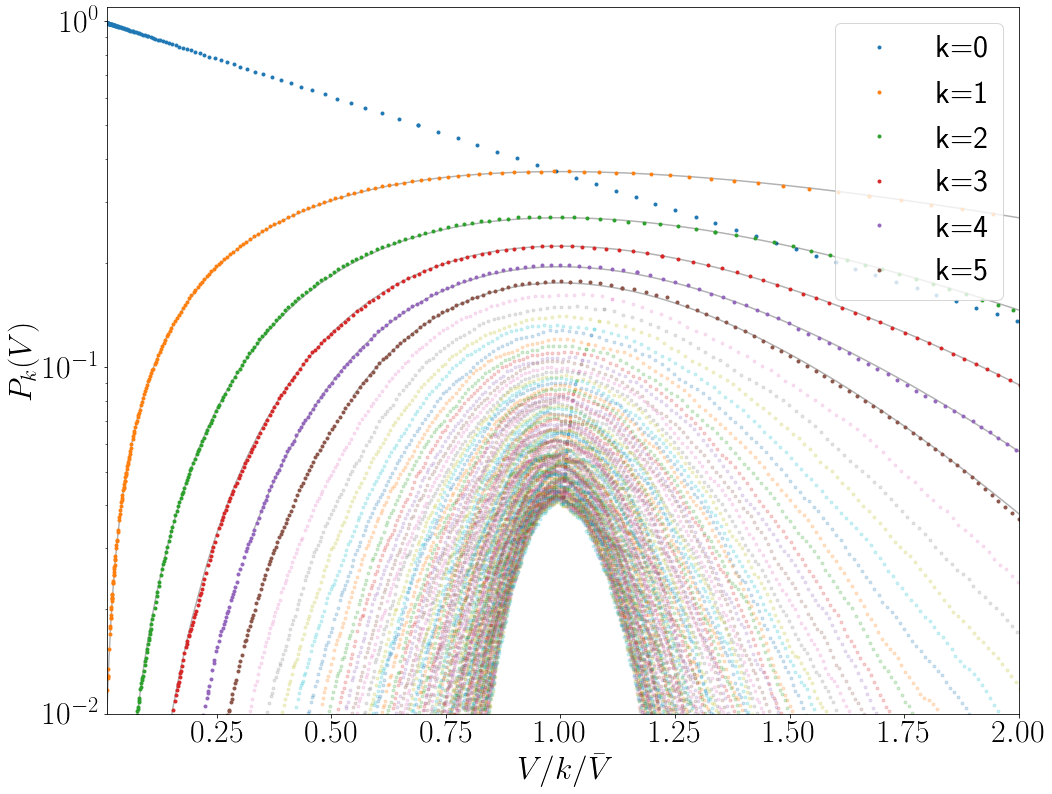

In [89]:
for k in range(0,100):
    vol = CDFs[k+1].f.x
    ck = np.max([k,1])
    lab = ""
    alf = .2    
    if (ck < 6 and ck > 0) :
        alf = 1
        lab = "k="+str(k)
        plt.plot(vol/Vbar,Erlang(k,NPois/boxsize**3,vol)/ck,'-',color="black",alpha=0.3)
    plt.plot(vol/ck/Vbar, Pks[k](vol),'.',alpha=alf,label=lab) 
plt.axhline(np.exp(-2.5**3))
plt.yscale("log")
plt.xlim([.01e0,2])
plt.ylim([1e-2,11e-1])
plt.ylabel(r"$P_{k}(V)$" )
plt.xlabel(r"$V/k/\bar{V}$" )
plt.legend()
plt.axvline(Vbar,alpha=.2);

Assemble Counts in Cell statistics and understand them as discrete statistical distributions

In [95]:
Nvols = 7
vols = np.logspace(0,2,Nvols)*Vbar
dCa = np.zeros((len(vols),len(kneighbors)))
for i, vol in enumerate(vols):
    dCa[i][:] = [Pks[k](vol) for k in kneighbors-1]

pC = [stats.rv_discrete(values=(kneighbors-1,np.round(dCa[i]/np.sum(dCa[i]), decimals=7)),\
    name='CountsInCell')  for i, vol in enumerate(vols)]

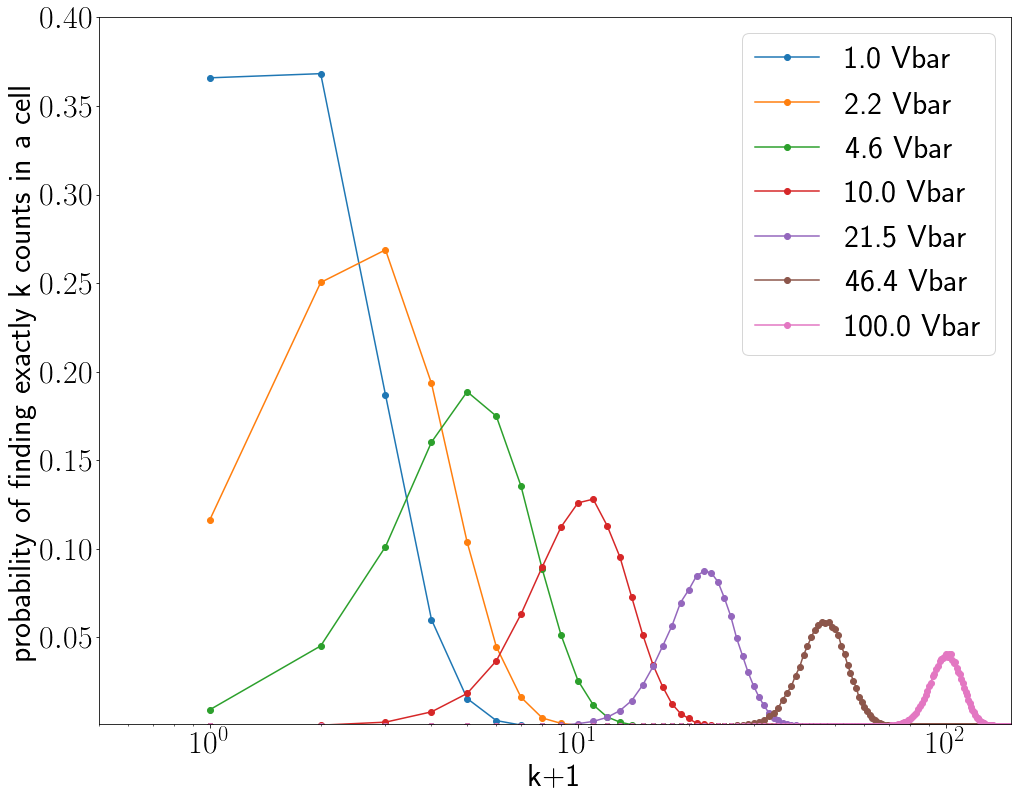

In [96]:
for i in range(Nvols):
    plt.plot(kneighbors,pC[i].pmf(kneighbors-1),'o-',label="%.1f Vbar" % (vols[i]/Vbar))
#plt.yscale("log")
plt.xscale("log")
plt.ylim([1e-3,.4])
plt.xlim([0.5,150])
plt.xlabel("k+1")
plt.legend();
plt.ylabel("probability of finding exactly k counts in a cell");

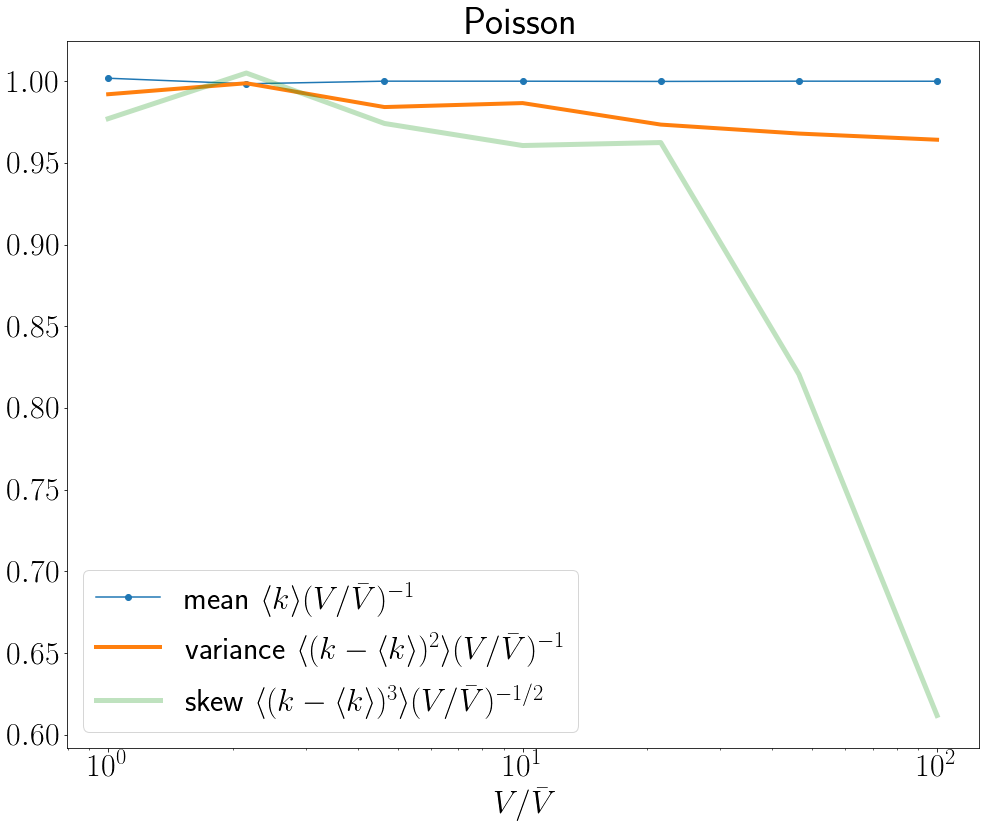

In [97]:
pkstat = np.array([pC[i].stats(moments="mvsk") for i, vol in enumerate(vols)])
pkstd = np.array([pC[i].std() for i, vol in enumerate(vols)])

pnv = vols/Vbar
plt.plot(pnv, pkstat[:,0]/pnv,'o-',label=r"mean $\langle k \rangle (V /\bar{V})^{-1}$")
plt.plot(pnv, pkstat[:,1]/pnv, lw=4, \
    label=r"variance $\langle (k - \langle k \rangle)^2 \rangle (V /\bar{V})^{-1}$")
plt.plot(pnv  , pkstat[:,2]/pnv**(-1/2),alpha=.3,lw=5, \
    label=r"skew $\langle (k - \langle k \rangle)^3 \rangle (V /\bar{V})^{-1/2}$")
plt.xscale("log")
plt.xlabel(r"$V/\bar{V}$")
plt.title("Poisson")
plt.legend();